In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import math

params = {
            'animation.html' : 'jshtml',
            'figure.figsize' : (16, 9),
            'legend.fontsize': 'x-large',
            'axes.labelsize': 'x-large',
            'axes.titlesize':'x-large',
            'xtick.labelsize':'x-large',
            'ytick.labelsize':'x-large'
         }

plt.rcParams.update(params)

## Auxiliary functions

In [12]:
def generate_binary_image(n, density):
    I = np.ones(shape = (n, n))
    zeros = int(n * n * density)

    while zeros > 0:
        point = np.random.randint(n, size = 2)
        x, y = point[0], point[1]
        if I[y][x] == 1:
            I[y][x] = 0
            zeros  -= 1
     
    return I

def distance(p1, p2):
    x1, y1 = p1
    x2, y2 = p2

    return math.sqrt(math.pow(x2 - x1, 2) + math.pow(y2 - y1, 2))

def rand_point(n):
    point = np.random.randint(n, size = 2)

    return (point[0], point[1])

def swap_points(p1, p2, I):
    (x1, y1) = p1
    (x2, y2) = p2

    I[y1][x1], I[y2][x2] = I[y2][x2], I[y1][x1]

## Neighbour functions

In [13]:
from functools import partial

dxs_4 = [-1, 0, 0, 1]
dys_4 = [0, -1, 1, 0]

def neighbours_v4(point, I):
    n = len(I)
    x, y = point
    neighs = []

    for i in range(4):
        nx, ny = x + dxs_4[i], y + dys_4[i]
        if not (nx < 0 or ny < 0 or nx >= n or ny >= n):
            neighs.append((nx, ny))

    return neighs

def neighbours_within_range(point, I, radius):
    n = len(I)
    x, y = point
    neighs = []

    for dy in range(-radius, radius + 1):
        for dx in range(-radius, radius + 1):
            nx, ny = x + dx, y + dy
            if not (nx < 0 or ny < 0 or nx >= n or ny >= n or (nx == x and ny == y)):
                neighs.append((nx, ny))
    
    return neighs


neighbours_v24 = partial(neighbours_within_range, radius = 2)

neighbours_v8  = partial(neighbours_within_range, radius = 1)

## Cost functions 
    (energy)

In [51]:
# This is how we calculate cost!
def simple_singleCostF(point, I, neighF):
    neighs = neighF(point, I)
    v1     = I[point[1], point[0]]
    cost   = 0.0
    for (x, y) in neighs:
        v2 = I[y][x]
        if v1 != v2:
            cost += distance(point, (x, y))

    return cost

def reversed_simple_singleCostF(point, I, neighF):
    neighs = neighF(point, I)
    v1     = I[point[1], point[0]]
    cost   = 0.0
    for (x, y) in neighs:
        v2 = I[y][x]
        if v1 == v2:
            cost += distance(point, (x, y))

    return cost

## This function runs only once since it's computationaly expensisve
def costF(I, neighF, singleCostF):
    cost = 0.0
    n = len(I)
    for y in range(n):
        for x in range(n):
            cost += singleCostF((x, y), I, neighF)

    return cost

def partialCostF(p1, p2, I, neighF, singleCostF):
    swap_points(p1, p2, I)

    before = singleCostF(p1, I, neighF) + singleCostF(p2, I, neighF)
    for point in neighF(p1, I):
        before += singleCostF(point, I, neighF)

    for point in neighF(p2, I):
        before += singleCostF(point, I, neighF)
    
    swap_points(p1, p2, I)

    now = singleCostF(p1, I, neighF) + singleCostF(p2, I, neighF)
    for point in neighF(p1, I):
        now += singleCostF(point, I, neighF)

    for point in neighF(p2, I):
        now += singleCostF(point, I, neighF)

    return now - before

## Cooling functions

In [76]:
def exponential_decay_v9(temp):
    return .9 * temp

def exponential_decay_v7(temp):
    return .7 * temp

def exponential_decay_v5(temp):
    return .5 * temp

## Functions generating new state
   (neighbour functions but the name is already taken)

In [53]:
def consecutive_swap(I, neighF):
    p1 = rand_point(n)
    neighs = neighF(p1, I)
    i = np.random.randint(len(fields))
    p2 = neighs[i]
    swap_points(p1, p2, I)

    return p1, p2

def rand_swap(I, neighF):
    n = len(I)
    p1, p2 = rand_point(n), rand_point(n)
    swap_points(p1, p2, I)

    return p1, p2

In [92]:
def bin_img_simuated_annealing(I, temp_start, temp_limit, tempF, stateF, neighF, singleCostF, breakAfter):
    n = len(I)
    epochs = 15 * n
    cost   = costF(I, neighF, singleCostF)
    moves  = 0
    temperature = temp_start

    while True:
        found = 0
        for i in range(epochs):
            moves += 1
            p1, p2 = stateF(I, neighF)
            alternate_cost = cost + partialCostF(p1, p2, I, neighF, singleCostF)
            delta = cost - alternate_cost

            if delta > 0 or (math.e ** (delta / temperature)) > np.random.rand():
                cost = alternate_cost
            else:
                swap_points(p2, p1, I)
            
            if delta > 0:
                found += 1
                if found > breakAfter:
                    break

        if found == 0 or temperature < temp_limit:
            break

        temperature = tempF(temperature)
    
    return I, moves

In [93]:
def solve(n, density, temp_start = 100.0, temp_limit = 1e-3,
          tempF = exponential_decay_v9, stateF = rand_swap,
          neighF = neighbours_v4, singleCostF = simple_singleCostF, breakAfter = 10):
    I = generate_binary_image(n, density)
    fig, axes = plt.subplots(nrows=1, ncols=2)
    axes[0].imshow(I, cmap = 'gray')

    bin_img_simuated_annealing(I, temp_start, temp_limit, tempF, stateF, neighF, singleCostF, breakAfter)
    axes[1].imshow(I, cmap = 'gray')
    
    plt.show()

## Solutions

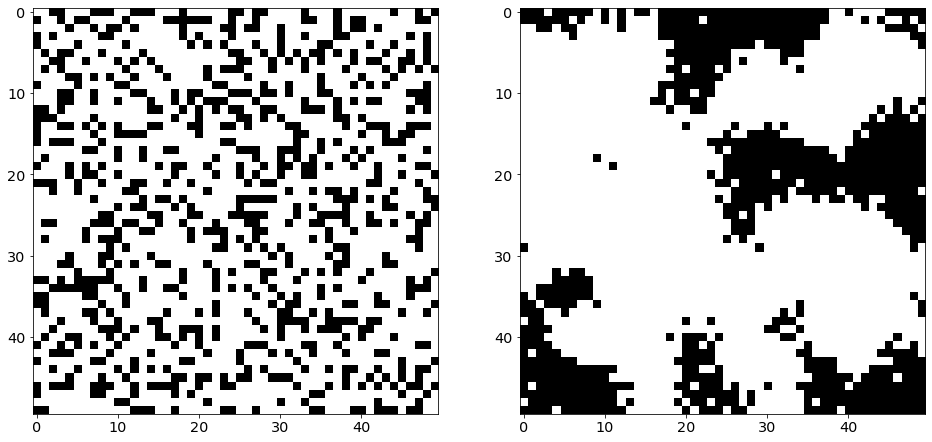

In [85]:
n, density = 50, .3
solve(n, density, neighF = neighbours_v24)

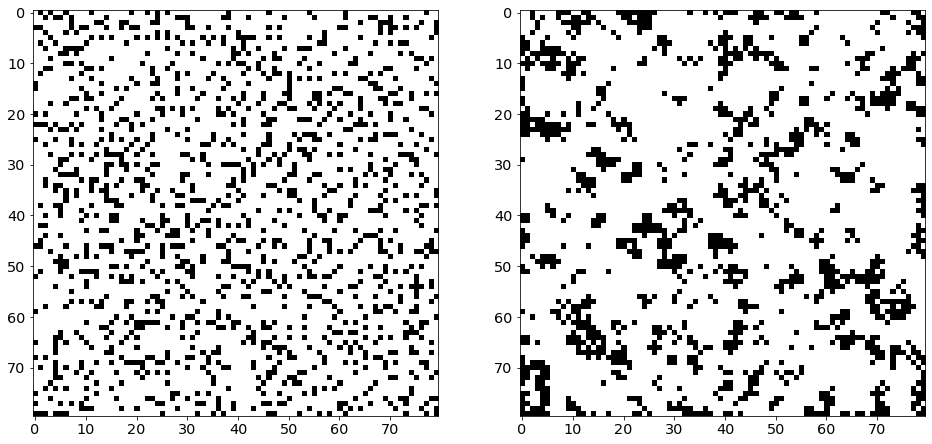

In [100]:
n, density = 80, .2
solve(n, density, neighF = neighbours_v8)

### How does neighbour function affect solution

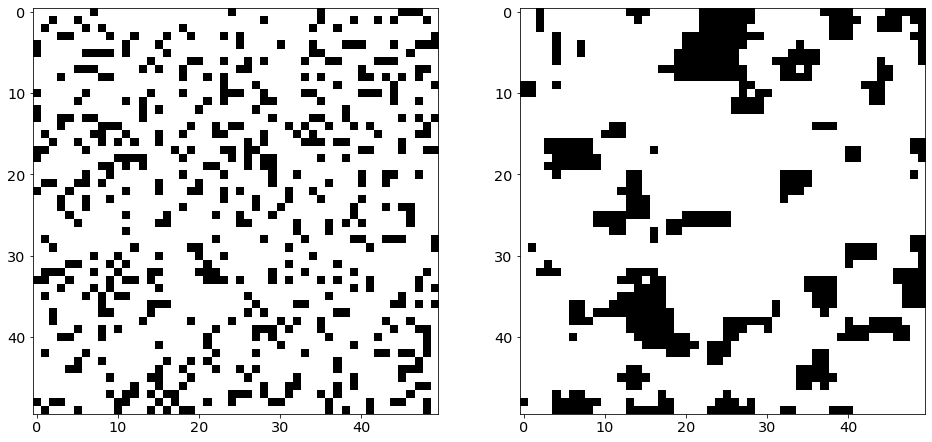

In [94]:
n, density = 50, .2
solve(n, density, neighF = neighbours_v4)

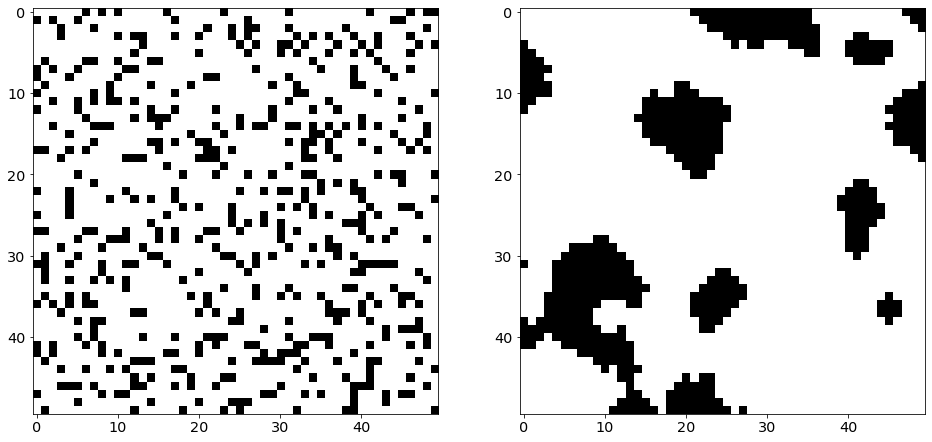

In [87]:
n, density = 50, .2
solve(n, density, neighF = neighbours_v8)

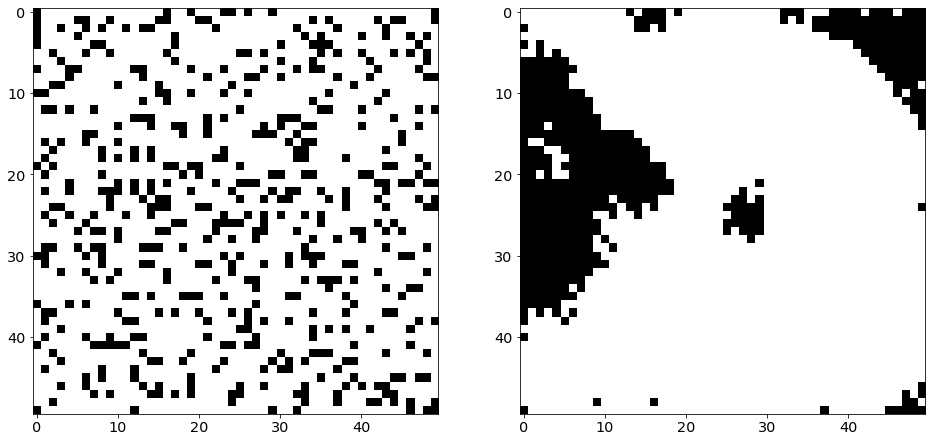

In [88]:
n, density = 50, .2
solve(n, density, neighF = neighbours_v24)

### How does cost function affect solution

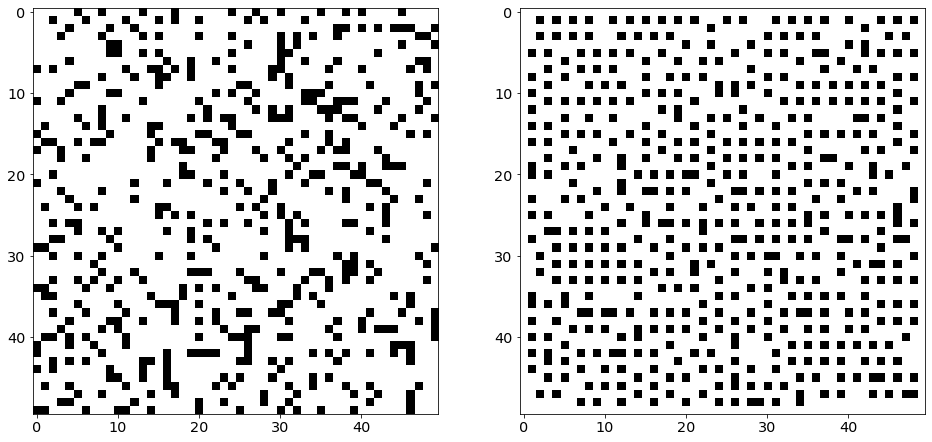

In [89]:
n, density = 50, .2
solve(n, density, singleCostF = reversed_simple_singleCostF, neighF = neighbours_v8)

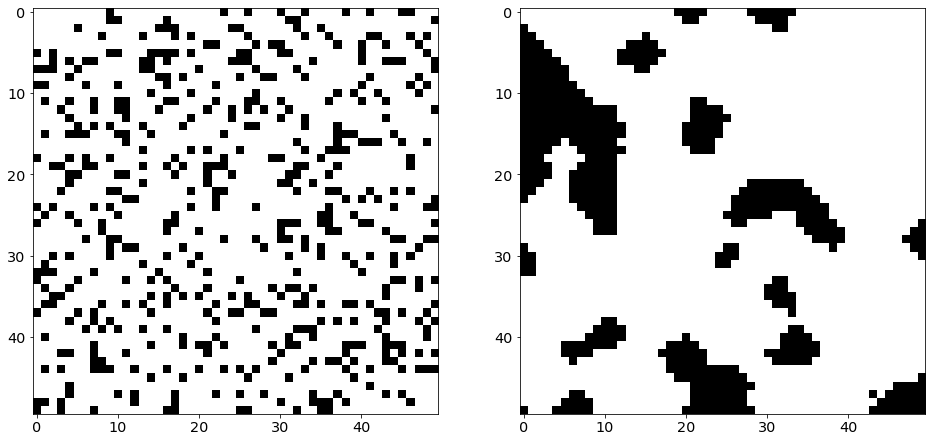

In [90]:
n, density = 50, .2
solve(n, density, singleCostF = simple_singleCostF, neighF = neighbours_v8)

### How does temperature function affect solution

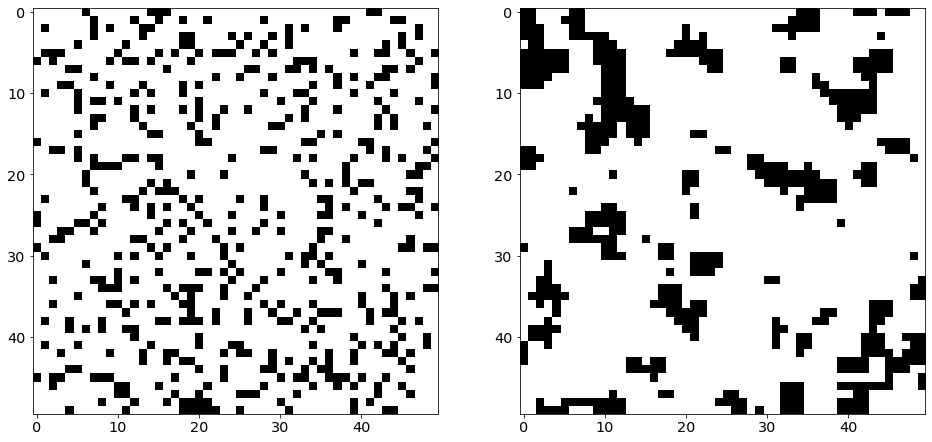

In [80]:
n, density = 50, .2
solve(n, density, tempF = exponential_decay_v9)

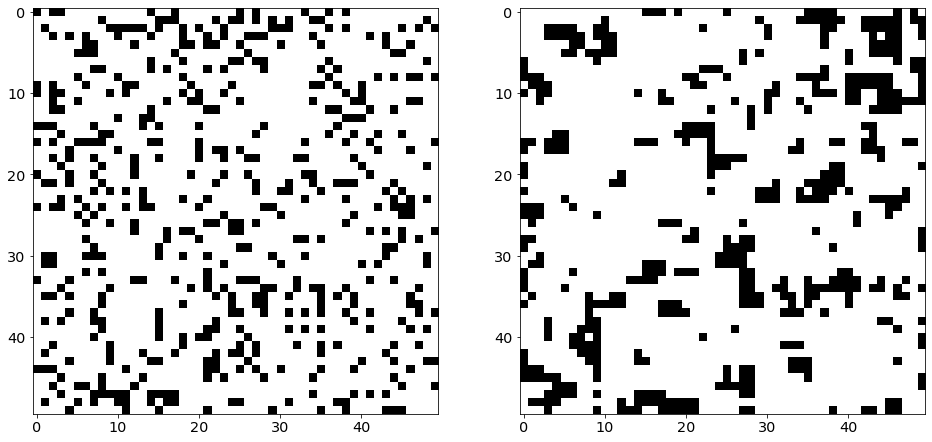

In [81]:
n, density = 50, .2
solve(n, density, tempF = exponential_decay_v7)

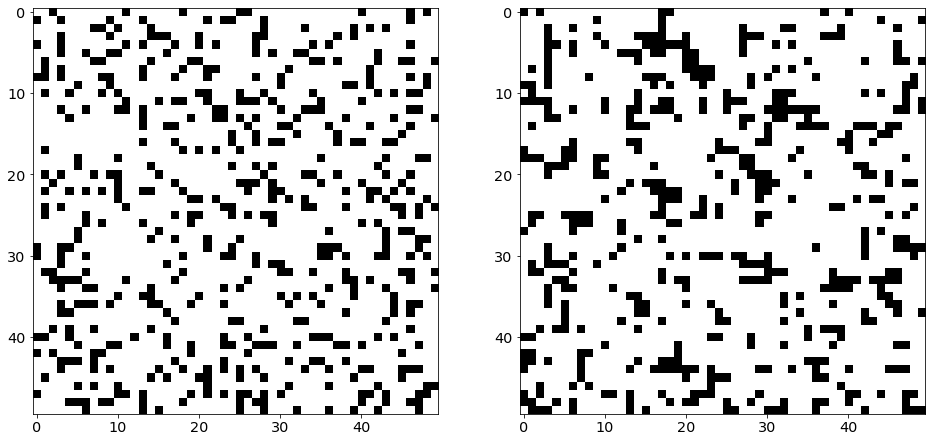

In [82]:
n, density = 50, .2
solve(n, density, tempF = exponential_decay_v5)